# Running Tensor-cell2cell to perform a tensor factorization

After generating a 4D-Communication Tensor, we can run Tensor-cell2cell to perform a tensor factorization and obtain the context-driven patterns of cell-cell communication.

This tutorial will guide users to load a previously exported 4D-Communication Tensor and run Tensor-cell2cell on that tensor.

## Initial Setup

**Before running this notebook** 

GPUs can substantially speed-up this analysis. If you are planning to use a NVIDIA GPU, make sure to have a proper NVIDIA GPU driver (https://www.nvidia.com/Download/index.aspx) as well as the CUDA toolkit (https://developer.nvidia.com/cuda-toolkit) installed.

Then, make sure to create an environment with PyTorch version >= v1.8.1 following these instructions to enable CUDA.

https://pytorch.org/get-started/locally/

### Enabling GPU use

If you are using a NVIDIA GPU, after installing PyTorch with CUDA enabled, specify `gpu_use = True`. Otherwise, `gpu_use = False`.

In [1]:
gpu_use = True

When using a GPU, first import tensorly and set the backend to be `'pytorch'`. 

In [2]:
if gpu_use:
    import tensorly as tl
    tl.set_backend('pytorch')

### Import Libraries

In [3]:
import cell2cell as c2c

import pandas as pd
import numpy as np

%matplotlib inline

## Load Tensor

Now, we can load our 4D-Communication Tensor that was previously exported with pickle.

In [4]:
tensor = c2c.io.read_data.load_tensor('BALF-Tensor.pkl')

Load metadata

In [5]:
meta_tensor = c2c.io.load_variable_with_pickle('BALF-Tensor-Metadata.pkl')

## Perform Tensor Factorization

Tensor-cell2cell can be run with a simple pipeline command that executes all important steps to perform the tensor factorization.

/home/erick/miniconda3/envs/cell2cell/lib/python3.9/site-packages/tensorly/backend/pytorch_backend.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data, dtype=dtype, device=device,


Running Elbow Analysis


  0%|          | 0/25 [00:00<?, ?it/s]

The rank at the elbow is: 9
Running Tensor Factorization


  0%|          | 0/100 [00:00<?, ?it/s]

Best model has a normalized error of: 0.438
Generating Outputs
Loadings of the tensor factorization were successfully saved into ../Figures//Loadings.xlsx


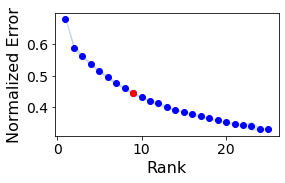

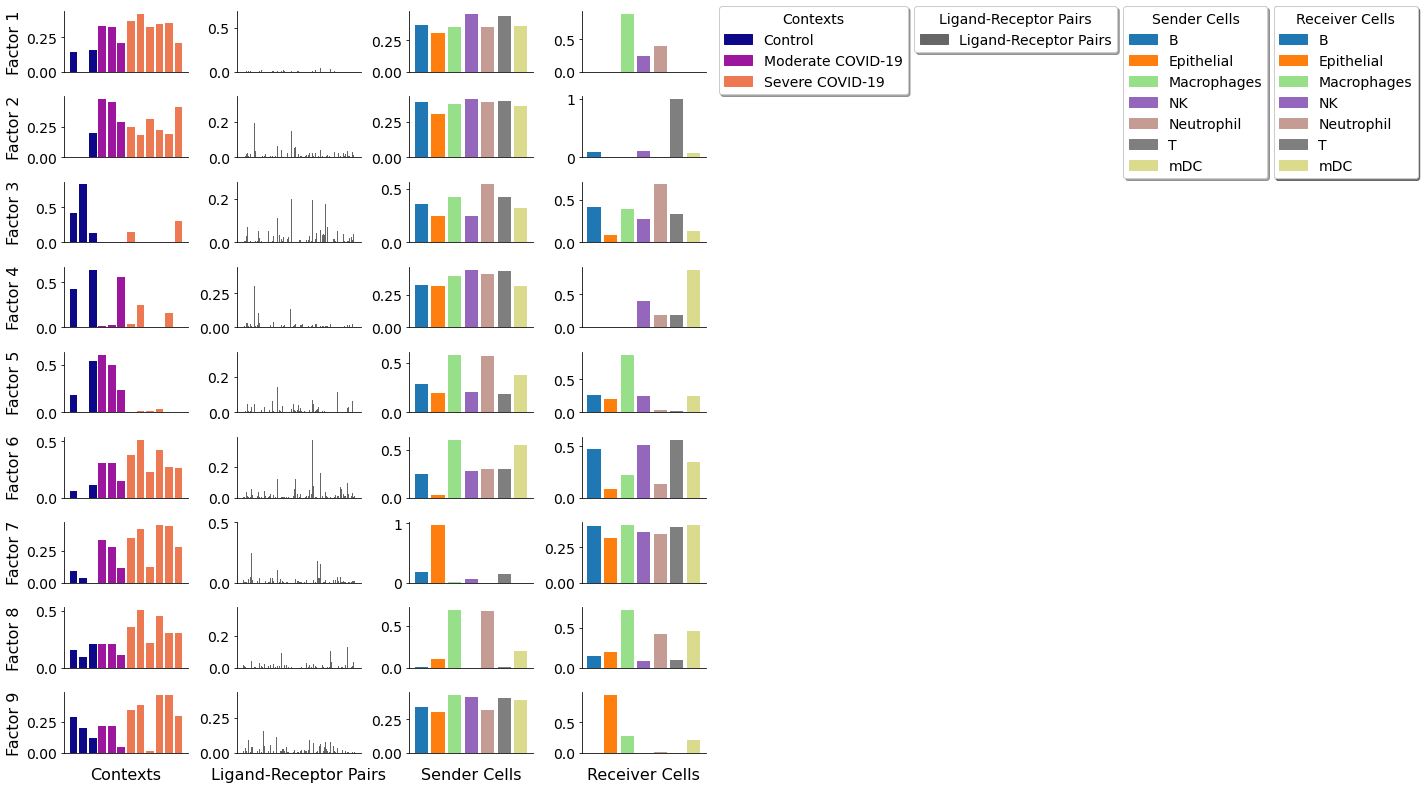

In [6]:
tensor2 = c2c.analysis.run_tensor_cell2cell_pipeline(tensor,
                                                     meta_tensor,
                                                     copy_tensor=True, # Whether to output a new tensor or modifying the original
                                                     rank=None, # Number of factors to perform the factorization. If None, it is automatically determined by an elbow analysis
                                                     tf_optimization='robust', # To define how robust we want the analysis to be.
                                                     random_state=None, # Random seed for reproducibility
                                                     device='cuda', # Device to use. If using GPU and PyTorch, use 'cuda'. For CPU use 'cpu'
                                                     elbow_metric='error', # Metric to use in the elbow analysis.
                                                     smooth_elbow=False, # Whether smoothing the metric of the elbow analysis.
                                                     upper_rank=25, # Max number of factors to try in the elbow analysis
                                                     tf_init='random', # Initialization method of the tensor factorization
                                                     tf_svd='numpy_svd', # Type of SVD to use if the initialization is 'svd'
                                                     cmaps=None, # Color palettes to use in color each of the dimensions. Must be a list of palettes.
                                                     sample_col='Element', # Columns containing the elements in the tensor metadata
                                                     group_col='Category', # Columns containing the major groups in the tensor metadata
                                                     fig_fontsize=14, # Fontsize of the figures generated
                                                     output_folder='../Figures/', # Whether to save the figures in files. If so, a folder pathname must be passed
                                                     output_fig=True, # Whether to output the figures. If False, figures won't be saved a files if a folder was passed in output_folder.
                                                     fig_format='pdf', # File format of the figures.
                                                    )